# Conditional Probability Binning

## Overview

This model leverages historical destination probabilities for all stations (calculated by type of day - weekday vs. weekend), and uses these conditional probabilities to predict the number of bikes that will arrive at each in the network on a given day based on the departure data from that day. 

As we'll soon observe, this model works rather well at predicting where bikes will end up up once we know where they left from (with predictions falling within a margin of two bikes for 95% of all arrivals in the given day I tested). While further validation is necesary, this early finding is encouraging as it suggests that travel patterns observed in our data may be somewhat consisten across months, or even years. 

I'll note that we have a pretty good sample size when analyzing patterns across an entire day (in our validation case, this number is 1197 bikes), but this story will soon be complicated as we pursue our lofty goal of predicting bike arrivals before they arrive. As most travel durations fall under 30 minutes, we'll be aiming to make arrival predictions in increments of time far smaller than 24 hours, which ultimately means we will be working with smaller numbers of departing bikes (compared to total bike departures for a day).   

But before we address those hurdles, let's take a look at how we came up with our conditional probabilities. 

## Load data

In [337]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pprint
%load_ext autoreload
from pylab import rcParams
import matplotlib.patches as mpatches

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [346]:
may_2015 = pd.read_csv('~/Code/bikesupply/data/test_data/trips_may2015.csv', parse_dates = ['start_date'])
may_2016 = pd.read_csv('~/Code/bikesupply/data/test_data/trips_may2016.csv', parse_dates = ['start_date'])

In [347]:
may_2015['start_date'] = pd.to_datetime(may_2015['start_date'])
may_2015['weekday'] = may_2015.start_date.dt.weekday

## Weekday probability distribution

I found very small training samples when I restrict by day type, so I opted to group all weekdays into one block, and aimed to test on a weekday in 2016. 

To evaulate performance, I defined a loss function that yields the following metrics:

* Type I rate - false possitive (we were expecting them, and they didn't show up) 
* Type II error rate - false negatives (they showed up and we weren't expecting them) 
* Mean absolute error 

In [353]:
def false_negatives(train, test, set_size):
    true_negatives = float(set_size - 1)
    test = list(test.index)
    train = list(train.index)
    n = 0
    for x in test:
        if x not in train:
            n += 1
    print "TYPE II (false negatives / divided by true negatives):", "%.2f" % (n / true_negatives)

def false_positives(train, test, set_size):
    true_negatives = float(set_size - 1)
    test = list(test.index)
    train = list(train.index)
    n = 0
    for x in train:
        if x not in test:
            n += 1
    print "TYPE I (false positives / true negatives):", "%.2f" % (n / true_negatives)
    
def mean_absolute_error(train, test):
    sums = 0.0
    n = float(max(len(train), len(test)))
    train_data = train
    test_data = test
    test_list = list(test.index)
    train_list = list(train.index)
    for x in train_list:
        if x in test_list:
            sums += abs(train_data.get(x) - test_data.get(x))
            train_list.pop(train_list.index(x))
            test_list.pop(test_list.index(x))
        else:
            sums += train_data.get(x)
            train_list.pop(train_list.index(x))
                   
    for x in test_list:
        sums += test_data.get(x)
        
    return round((sums / n), 2)

def one_station_loss_function(train, test, set_size, target_station, test_day):
    train_station = train.query("start_station_id == {}".format(target_station))
    test_station = test.query('start_day == {} and start_station_id == {}'.format(test_day, target_station))
    train_station_ids = train_station.groupby(['end_station_id'])['trip_id'].count() / len(train_station)
    test_station_ids = test_station.groupby(['end_station_id'])['trip_id'].count() 
    binned_data = train_station_ids * len(test_station)
    binned_data = binned_data[binned_data >= 0.3]
    
    print "Mean Absolute Error:", mean_absolute_error(binned_data, test_station_ids)

In [354]:
may_2015_weekdays = may_2015.query("weekday >= 0 and weekday <= 4")

In [355]:
# STATION 50
one_station_loss_function(may_2015_weekdays, may_2016, 84, 50, 2)

Mean Absolute Error: 1.64


In [356]:
# STATION 70
one_station_loss_function(may_2015_weekdays, may_2016, 84, 70, 2)

Mean Absolute Error: 2.29


In [357]:
def station_data_split(train, test, test_day, station_id):
    train_station = train.query("start_station_id == {}".format(station_id))
    train_station_ids = train_station.groupby(['end_station_id'])['trip_id'].count() / len(train_station)
    test_station = test.query('start_day == {} and start_station_id == {}'.format(test_day, station_id))
    test_station_ids = test_station.groupby(['end_station_id'])['trip_id'].count() 
    binned_data = train_station_ids * len(test_station)
    binned_data = binned_data[binned_data >= 0.3]
    
    return binned_data, test_station_ids

def plot_features(binned_data, test_station_ids, test_day, station_id):
    rcParams['figure.figsize'] =  12, 6
    plt.scatter(binned_data.index, binned_data, color = 'blue')
    plt.scatter(test_station_ids.index, test_station_ids, color = 'green')
    pred = mpatches.Patch(color='blue', label='Predicted')
    actual = mpatches.Patch(color='green', label='Actuals')
    plt.legend(handles=[pred, actual], loc=2)
    plt.title("Station {}".format(station_id))
    plt.show()

In [366]:
# How many bikes total moved on May 2, 2016?
len(may_2016.query("start_day == 2"))

1197

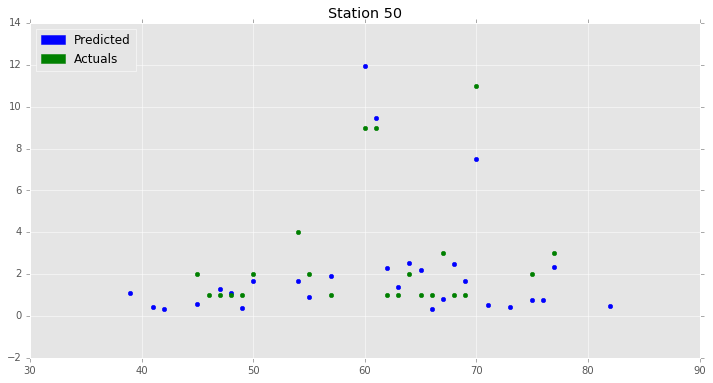

In [358]:
station_50_train, station_50_test = station_data_split(may_2015_weekdays, may_2016, 2, 50)
plot_features(station_50_train, station_50_test, 2, 50)

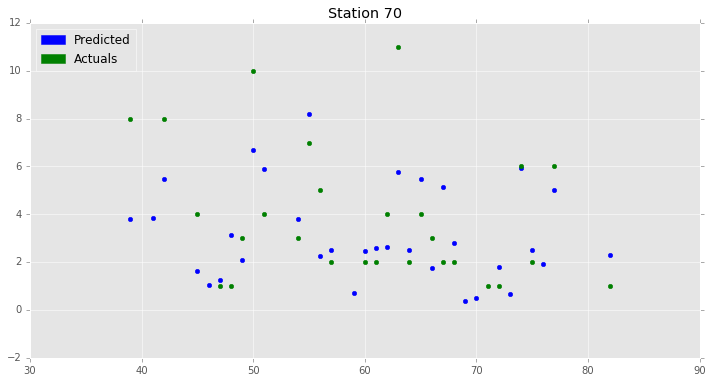

In [359]:
station_70_train, station_70_test = station_data_split(may_2015_weekdays, may_2016, 2, 70)
plot_features(station_70_train, station_70_test, 2, 70)

In [360]:
def multiple_station_loss_function(train, test, set_size):
    d = {}
    for i in range(set_size):
        train_station = train.query("start_station_id == {}".format(i))
        test_station = test.query('start_day == 2 and start_station_id == {}'.format(i))
        if i in list(train.start_station_id.values) and len(test_station) > 0:
            train_station_ids = train_station.groupby(['end_station_id'])['trip_id'].count() / len(train_station)
            test_station_ids = test_station.groupby(['end_station_id'])['trip_id'].count() 
            binned_data = train_station_ids * len(test_station)
            binned_data = binned_data[binned_data >= 0.3]
            d[i] = mean_absolute_error(binned_data, test_station_ids)
    return d

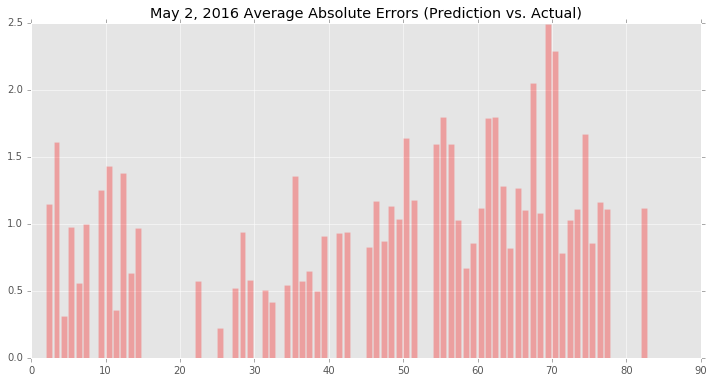

In [361]:
values = multiple_station_loss_function(may_2015_weekdays, may_2016, 84)
plt.bar(values.keys(), values.values(), color = 'red', alpha = 0.3) 
plt.title("May 2, 2016 Average Absolute Errors (Prediction vs. Actual)")

In [364]:
def percent_one_or_below(data):
    n = float(len(data))
    counts = 0
    l = data.values()
    for x in l:
        if x <= 2.0:
            counts += 1
    return round((counts / n), 2)

In [365]:
print percent_one_or_below(values)

0.95


95% of predictions for May 2, 2016 station arrivals (both station and number of bikes) based on soley on departure data were within an average accuracy of 2 bikes. 

## Time estimates

In [3]:
def create_time_columns(data, date_column, hour_column, minutes_column, delta_column):
    data[date_column] = pd.to_datetime(data[date_column])
    data = data.set_index(date_column)
    data[hour_column] = [ts.hour for ts in data.index]
    data[minutes_column] = [ts.minute for ts in data.index]
    data[delta_column] = (data[hour_column] * 60) + data[minutes_column]
    data = data.reset_index()
    return data
                                
create_time_columns(may_2015, 'end_date', 'end_hour', 'end_minutes', 'end_time_in_mins')
create_time_columns(may_2016, 'start_date', 'start_hour', 'start_minutes', 'start_time_in_mins')                      